In [23]:
import sys

sys.path.append("../")

import jax
import jax.numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import optax
from tqdm import tqdm, trange
import flax

import math
from functools import partial
import matplotlib.pyplot as plt

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from models.mlp_mixer import MLPMixer
from models.utils import get_timestep_embedding, karras_boundaries, TrainState, apply_ema_decay

In [24]:
key = jax.random.PRNGKey(42)
score = MLPMixer(4, 4, 64, 512, 512)

x = jax.random.normal(key, (4, 28, 28, 1))
t = np.ones((4, 16))

out, params = score.init_with_output(key, x, t)

In [25]:
sum(x.size for x in jax.tree_leaves(params))

/tmp/ipykernel_28862/236323635.py:1: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  sum(x.size for x in jax.tree_leaves(params))


487060

In [27]:
num_batch = 256
d_t_emb = 16

# Load MNIST dataset
mnist_dataset, mnist_info = tfds.load(name="mnist", with_info=True, as_supervised=True)

# Split dataset into training and testing sets
mnist_train, mnist_test = mnist_dataset["train"], mnist_dataset["test"]

mean = 0.1307
std = 0.3081

# Define function to normalize pixel values
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255
    image = (image - mean) / std
    return image, label

# Apply normalization to both training and testing sets
mnist_train = mnist_train.map(normalize)
mnist_test = mnist_test.map(normalize)

# Shuffle and batch the training set
mnist_train = mnist_train.shuffle(mnist_info.splits["train"].num_examples)
mnist_train = mnist_train.batch(num_batch)
mnist_train = mnist_train.cache().repeat()

# Batch the testing set
mnist_test = mnist_test.batch(num_batch)

batches = iter(mnist_train)

In [14]:
def f_theta(params, score, x, t):

    sigma_data = 0.5

    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)

    t = t[..., 0]
    t = get_timestep_embedding(t, d_t_emb)
    x_out = score.apply(params, x, t)

    return x * c_skip[:, :, None, None] + x_out * c_out[:, :, None, None]


@partial(jax.jit, static_argnums=(5,))
def loss_fn(params, params_ema, x, t1, t2, score, key):

    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2[:, :, None, None]
    x2 = f_theta(params, score, x2, t2)

    x1 = x + z * t1[:, :, None, None]
    x1 = f_theta(params_ema, score, x1, t1)

    return np.mean((x1 - x2) ** 2)


score = MLPMixer(4, 4, 64, 512, 512)

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (4, 28, 28, 1))
t = np.ones((4, d_t_emb))
params = score.init(key, x, t)

tx = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
state = TrainState.create(apply_fn=score.apply, params=params, tx=tx, params_ema=params)

num_steps = 50000

s0 = 2
s1 = 150
mu0 = 0.9
eps = 0.002
T = 60.0

@partial(jax.jit, static_argnums=(5,6,))
def train_step(state, batch, t1, t2, key, model, loss_fn, mu):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state.params_ema, x_batch, t1, t2, model, key)
    state = state.apply_gradients(grads=grads)
    state = apply_ema_decay(state, mu)
    return state, loss
    
with trange(num_steps) as steps:
    for step in steps:

        x_batch, y_batch = next(batches)
        x_batch, y_batch = x_batch._numpy(), y_batch._numpy()

        N = math.ceil(math.sqrt((step * ((s1 + 1) ** 2 - s0**2) / num_steps) + s0**2) - 1) + 1
        mu = math.exp(s0 * math.log(mu0) / N)

        boundaries = karras_boundaries(7.0, eps, N, T)

        key, _ = jax.random.split(key)
        n_batch = jax.random.randint(key, minval=0, maxval=N, shape=(x_batch.shape[0], 1))

        key, _ = jax.random.split(key)
        
        state, loss = train_step(state, x_batch, boundaries[n_batch], boundaries[n_batch + 1], key, score, loss_fn, mu)

        steps.set_postfix(val=loss)

100%|███████████████████████████████| 10000/10000 [04:50<00:00, 34.37it/s, val=0.00032855928]


In [15]:
def sample(params, score, ts, key):
    
    x0 = jax.random.normal(key, shape=(n_samples, 28, 28, 1)) * ts[0]
    x = f_theta(params, score, x0, np.repeat(ts[0], x0.shape[0])[:, None])
    for t in ts[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = f_theta(params, score, x, np.repeat(t, x0.shape[0])[:, None])
        
    return x

n_samples = 10
key = jax.random.PRNGKey(32)
x_samples = sample(state.params, score, list(reversed([0.1, 2., T / 4., T / 2., T])), key)

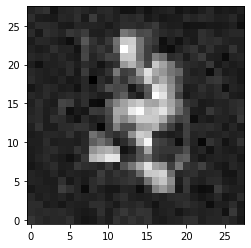

In [22]:
plt.imshow(x_samples[43, :, :, 0], origin='lower', cmap='binary_r')

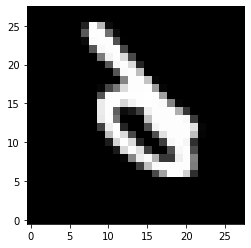

In [17]:
plt.imshow(np.array(x_batch[5, :, :, 0]), origin='lower', cmap='binary_r')